21.8 +/- 1.9
19.3 +/- 1.7


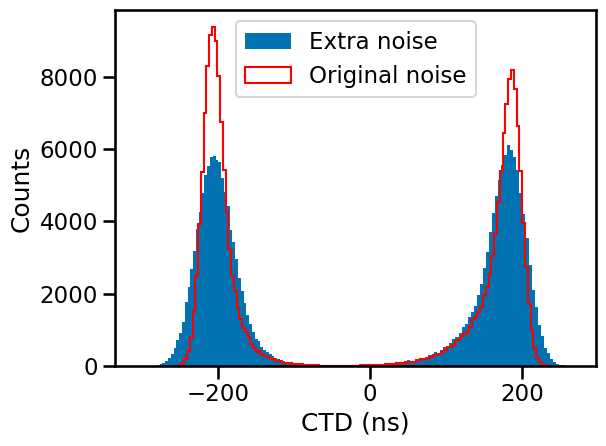

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

plt.figure()
plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
plt.legend()
plt.xlabel('CTD (ns)')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

# Look at all Cs137 data prior to Loma Linda

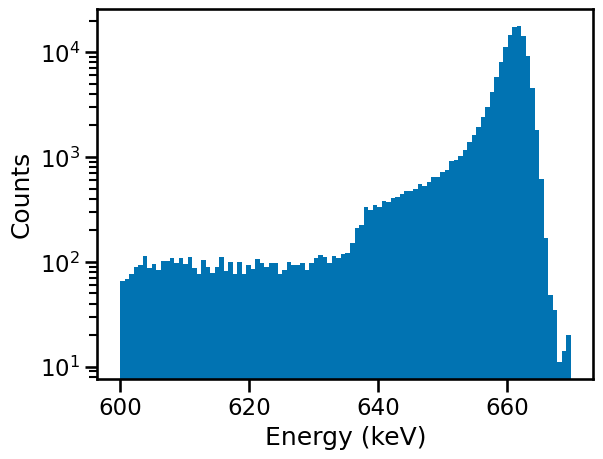

FWHM = 4.05
FWTM = 9.47


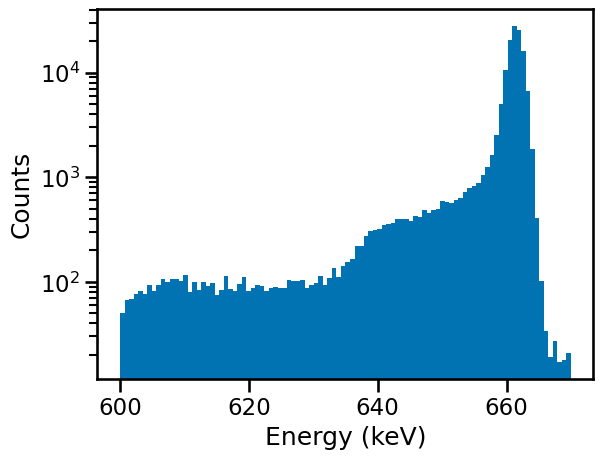

FWHM = 2.7
FWTM = 5.29


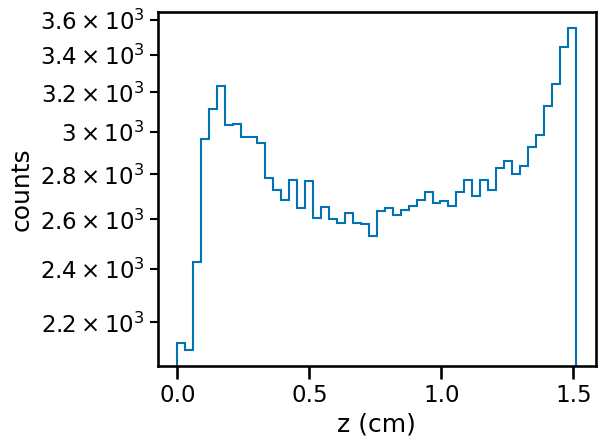

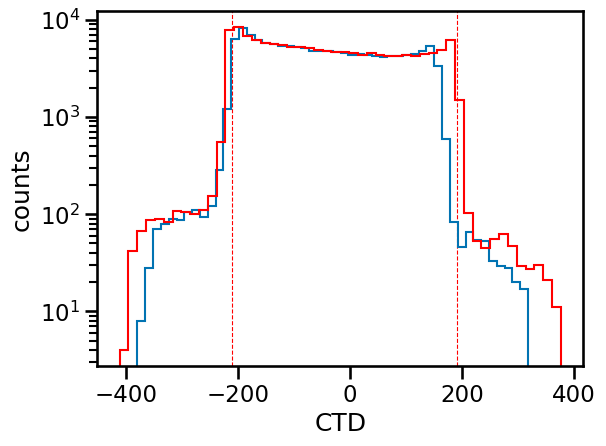

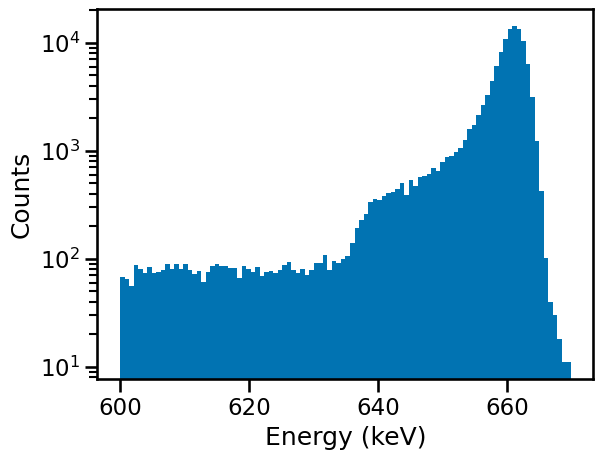

FWHM = 4.41
FWTM = 10.74


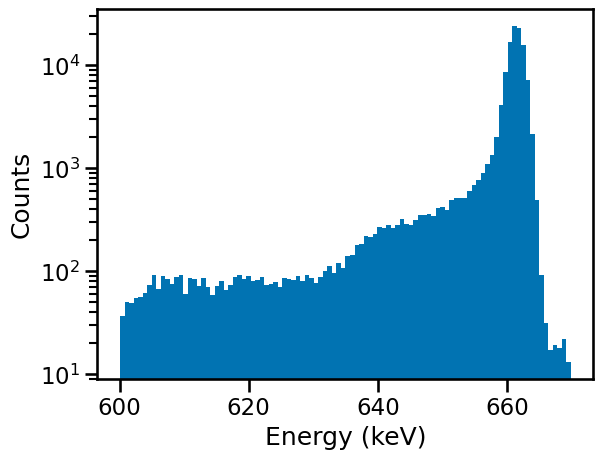

FWHM = 2.76
FWTM = 5.37


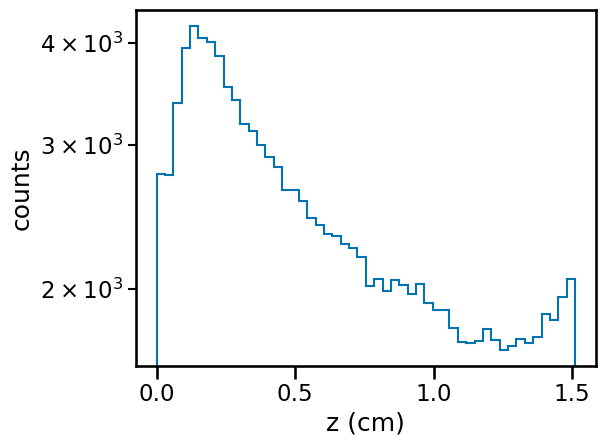

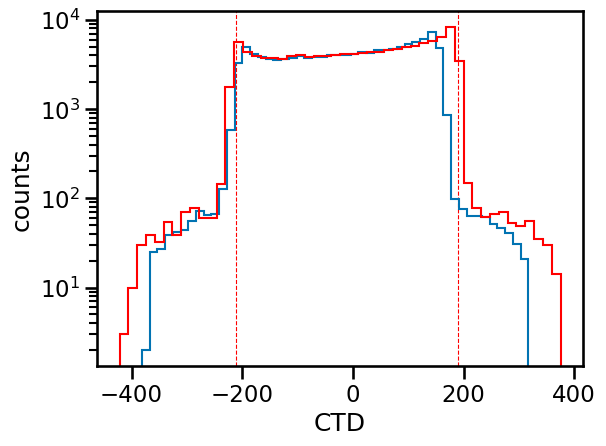

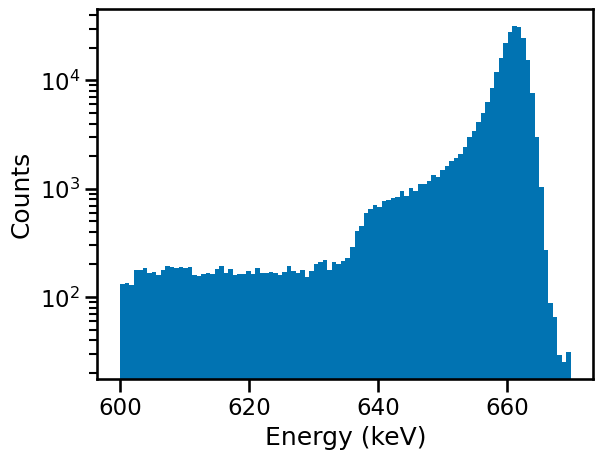

FWHM = 4.21
FWTM = 10.12


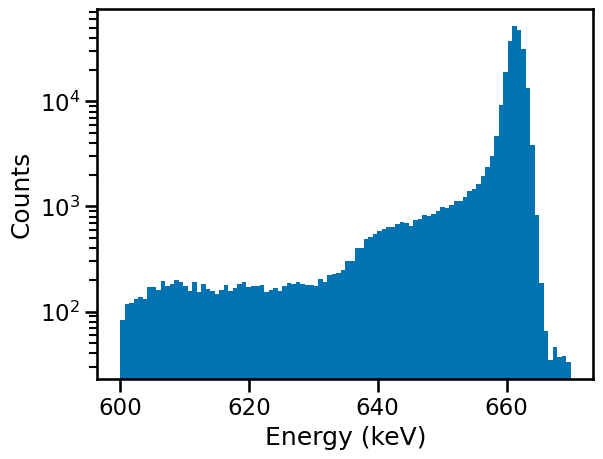

FWHM = 2.73
FWTM = 5.33


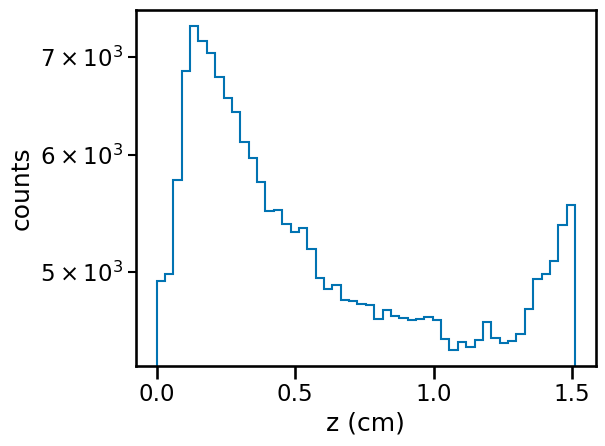

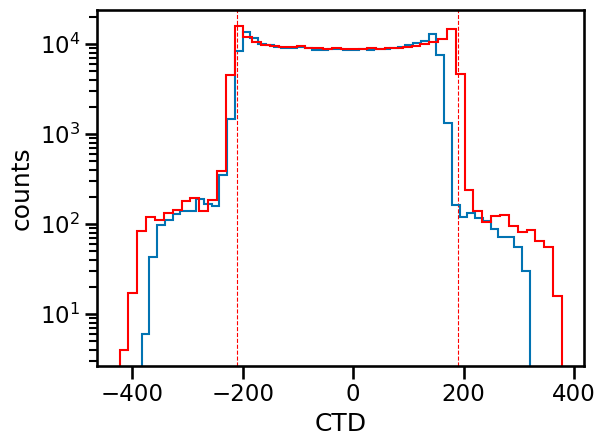

In [2]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_preLL', 'allDC_preLL', 'allACandDC_preLL']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

# Do the same for the data after LL round 1

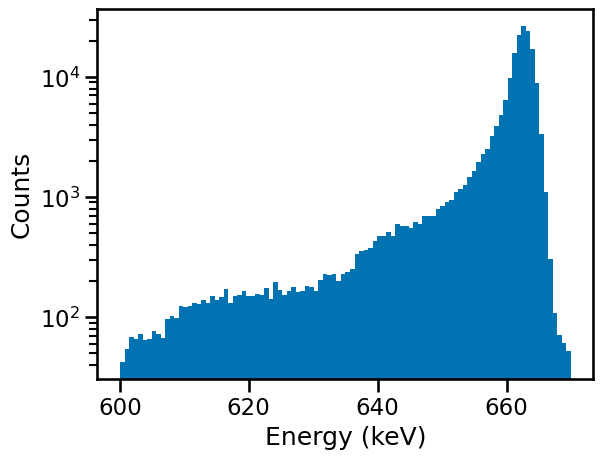

FWHM = 3.39
FWTM = 8.37


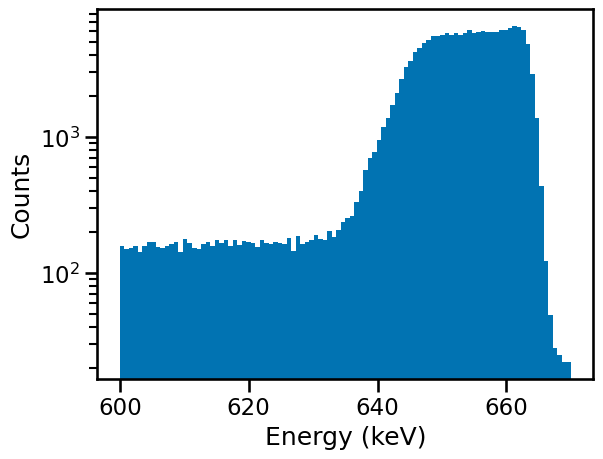

FWHM = 19.45
FWTM = 26.67


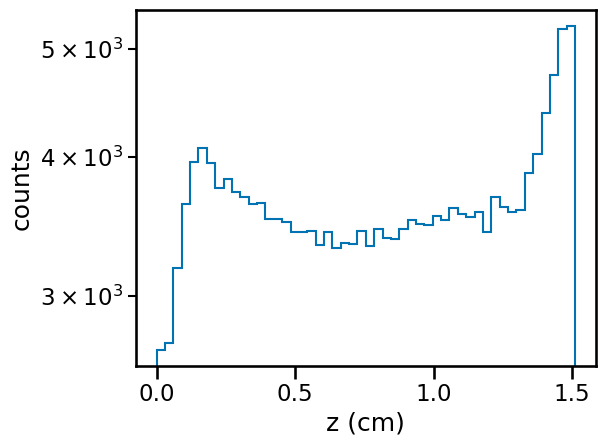

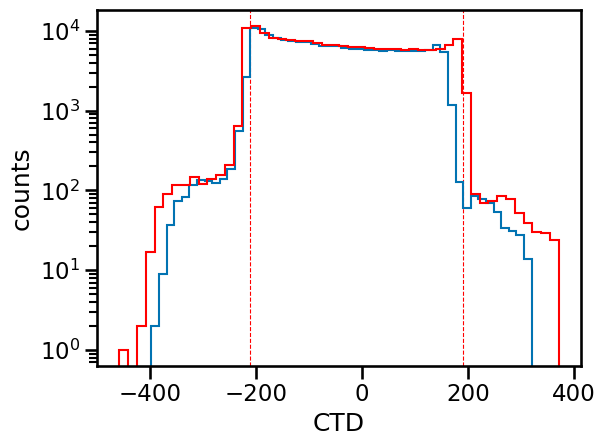

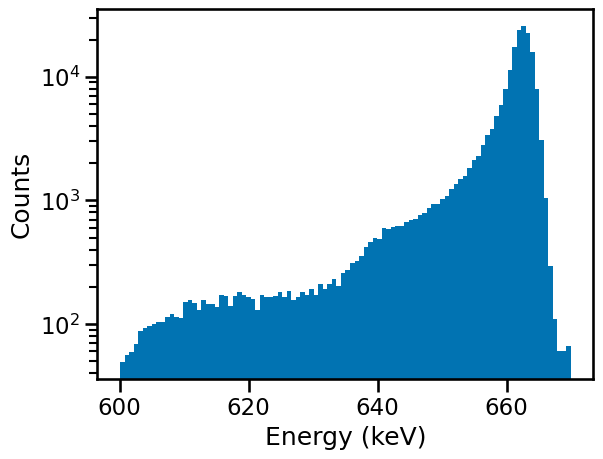

FWHM = 3.57
FWTM = 9.5


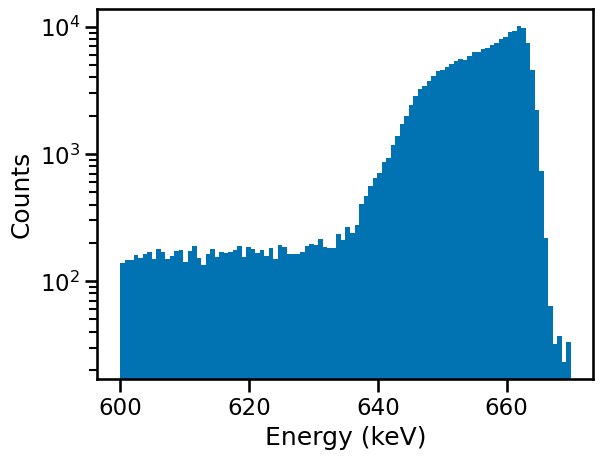

FWHM = 12.55
FWTM = 23.35


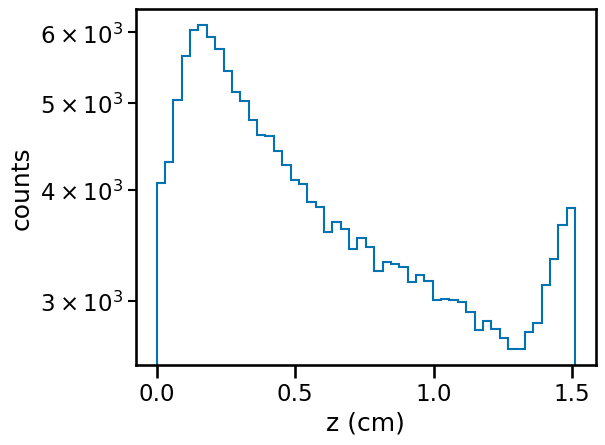

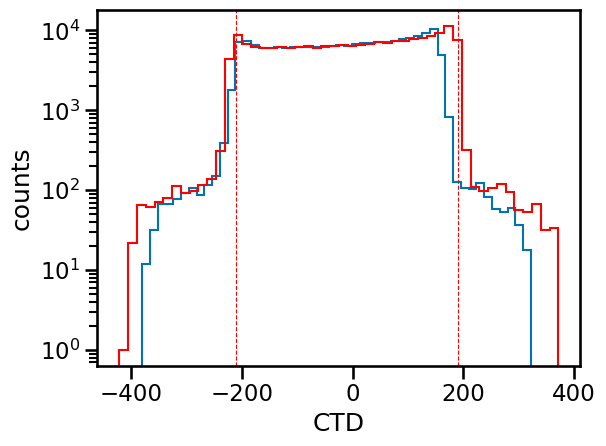

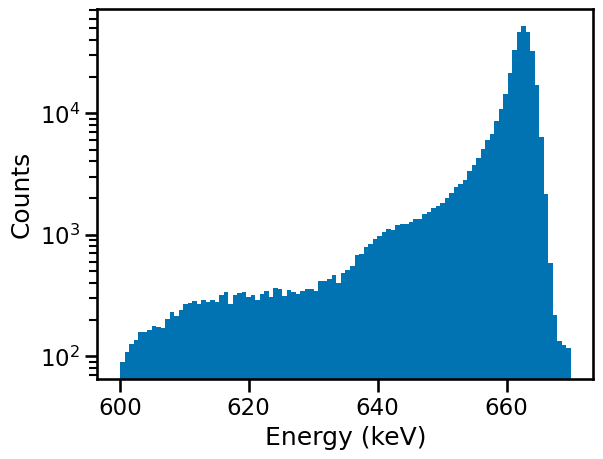

FWHM = 3.49
FWTM = 9.14


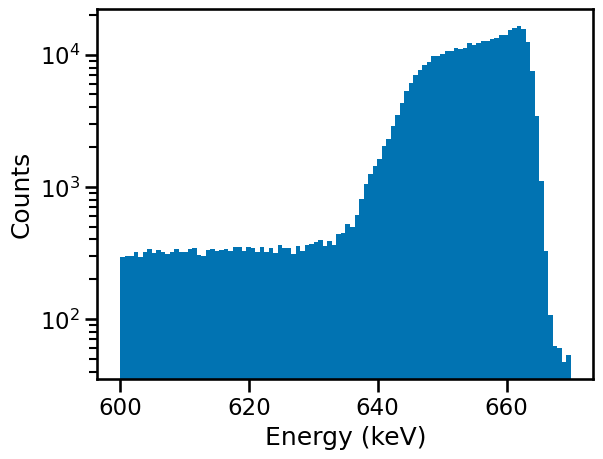

FWHM = 16.91
FWTM = 24.95


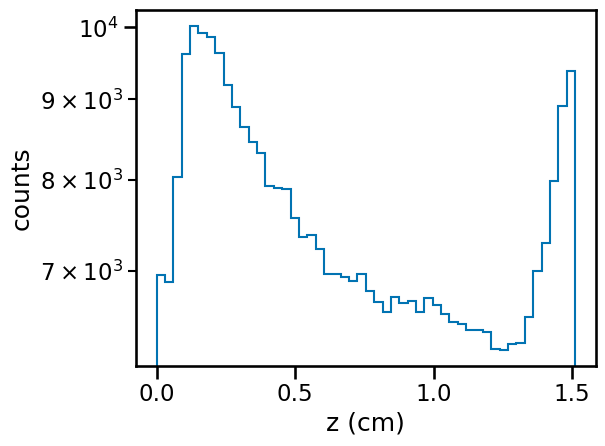

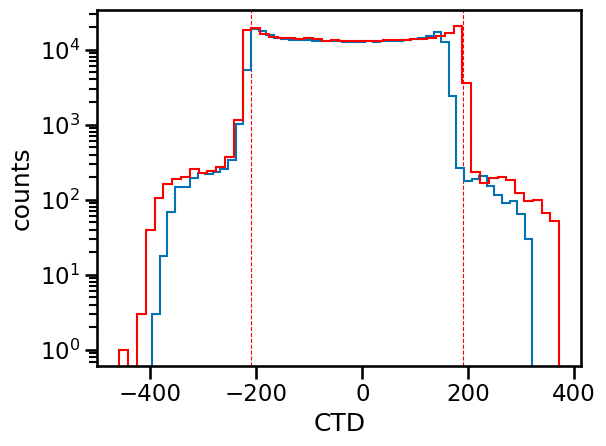

In [3]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL1', 'allDC_postLL1', 'allACandDC_postLL1']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [4]:
plt.figure()
plt.errorbar(z_list, e_signal_preLL[0], xerr = (z_list[1]-z_list[0])/2., yerr=e_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, e_signal_postLL1[0], xerr = (z_list[1]-z_list[0])/2., yerr=e_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=4)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_trapping_before_afterLL1.pdf')
plt.close()

plt.figure()
plt.errorbar(z_list, h_signal_preLL[0], xerr = (z_list[1]-z_list[0])/2., yerr=h_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, h_signal_postLL1[0], xerr = (z_list[1]-z_list[0])/2., yerr=h_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=3)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'hole_trapping_before_afterLL1.pdf')
plt.close()


# Perform correction using spline

In [5]:
df = depth_correction(df_list[-1], z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'allACandDC_postLL1')

FWHM = 3.49
FWTM = 9.14
FWHM = 3.36
FWTM = 8.7
FWHM = 16.91
FWTM = 24.95
FWHM = 3.87
FWTM = 9.26


# Same for after LL round 2

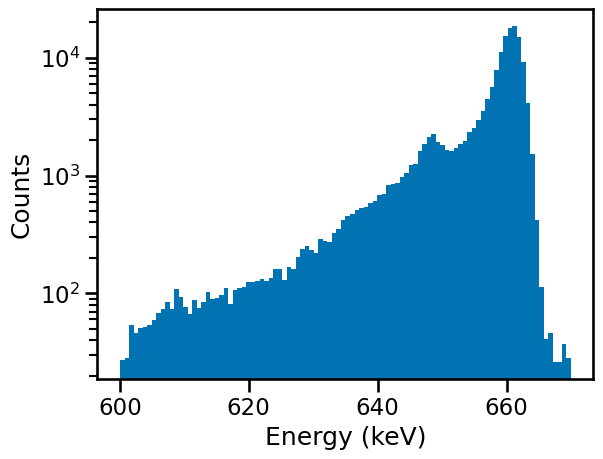

FWHM = 3.86
FWTM = 16.64


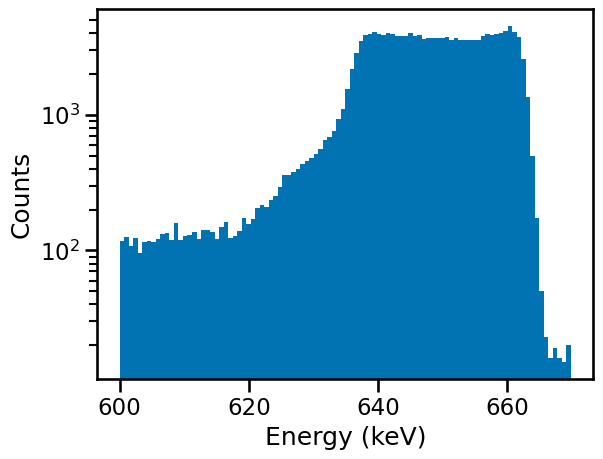

FWHM = 26.66
FWTM = 35.34


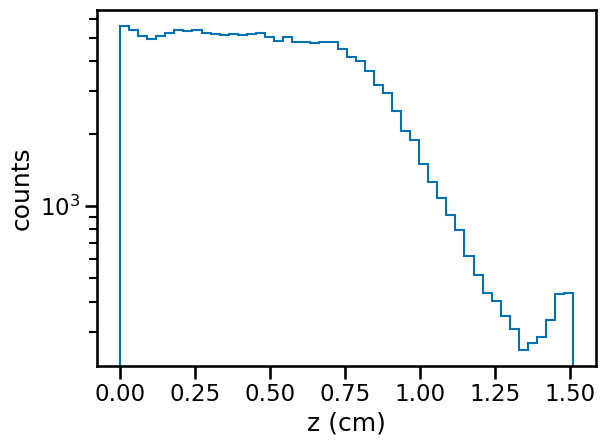

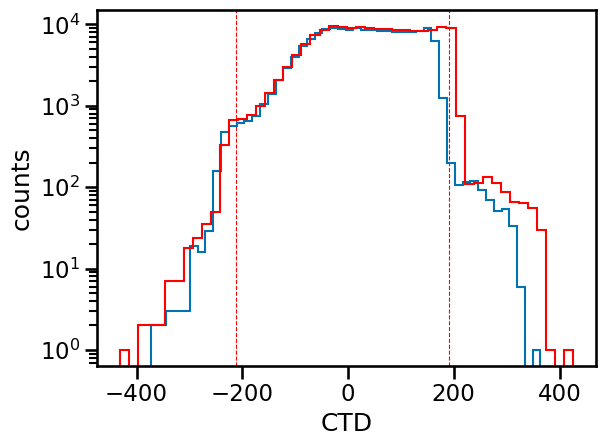

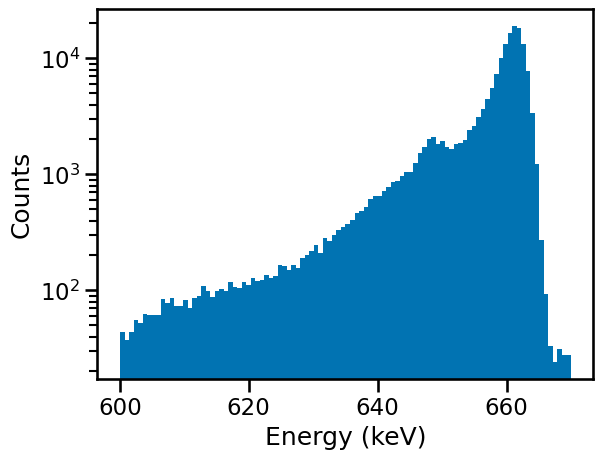

FWHM = 4.13
FWTM = 16.78


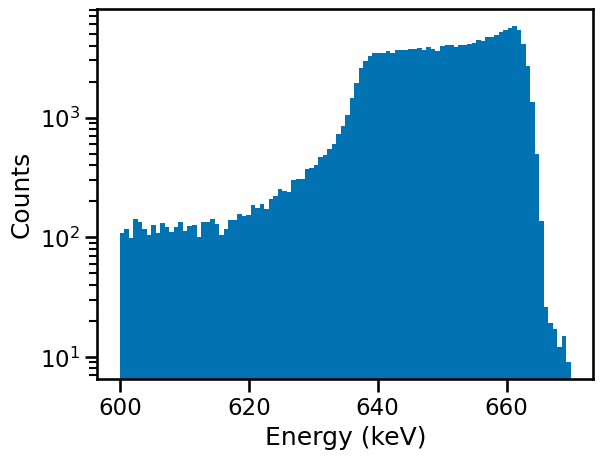

FWHM = 25.3
FWTM = 31.57


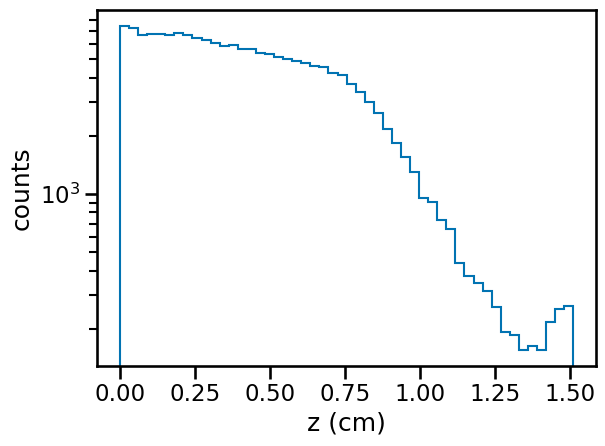

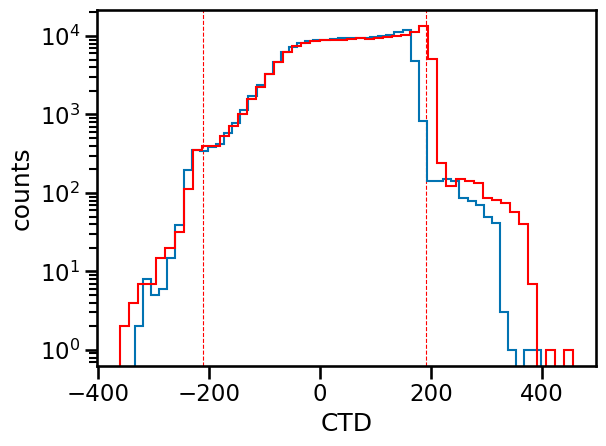

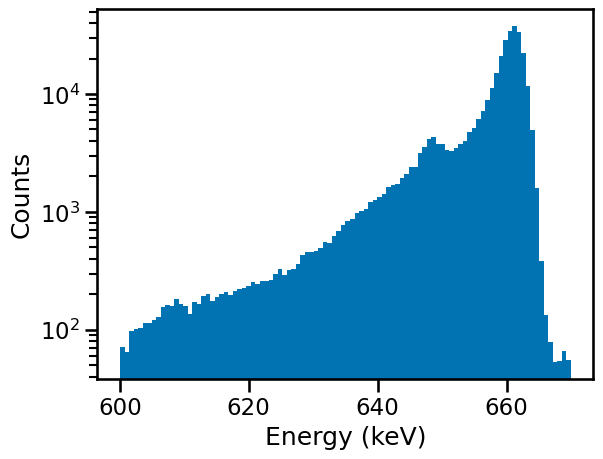

FWHM = 3.96
FWTM = 16.72


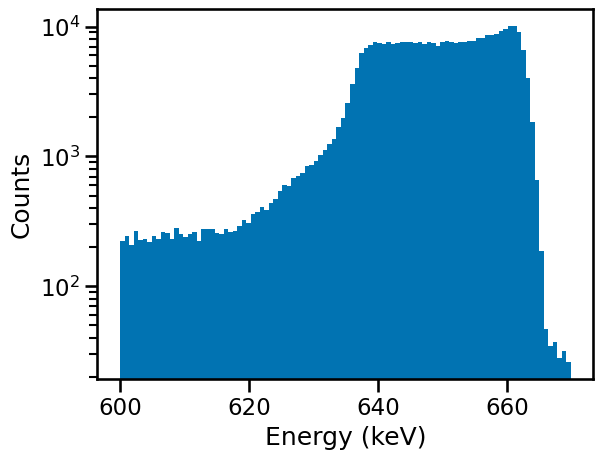

FWHM = 26.17
FWTM = 33.46


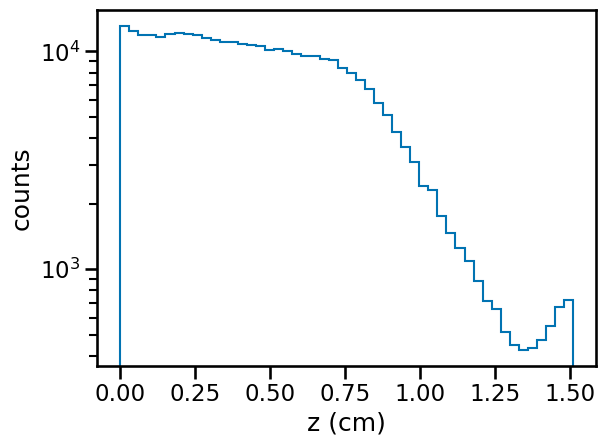

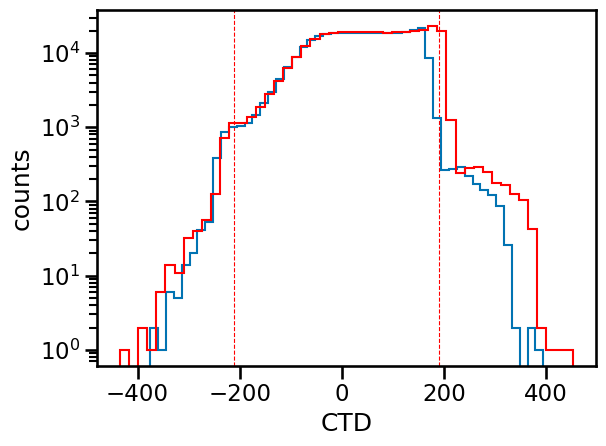

In [7]:
AC_list = ['20231120_Cs137_AC_600V.dat', '20231205_Cs137_AC_600V.dat', '20231208_Cs137_AC_600V.dat', '20231127_Cs137_AC_600V.dat', '20231206_Cs137_AC_600V.dat', '20231204_Cs137_AC_600V.dat', '20231207_Cs137_AC_600V.dat']
DC_list = ['20231122_Cs137_DC_600V.dat', '20231129_Cs137_DC_600V.dat', '20231201_Cs137_DC_600V.dat', '20231128_Cs137_DC_600V.dat', '20231130_Cs137_DC_600V.dat', '20231215_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL2', 'allDC_postLL2', 'allACandDC_postLL2']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL2/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL2, h_signal_postLL2 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [8]:
df = depth_correction(df_list[-1], z_list, e_signal_postLL2, h_signal_postLL2, plot_suffix = 'allACandDC_postLL2')

FWHM = 3.96
FWTM = 16.72
FWHM = 4.05
FWTM = 15.59
FWHM = 26.17
FWTM = 33.46
FWHM = 5.88
FWTM = 12.29


# After room temp anneal

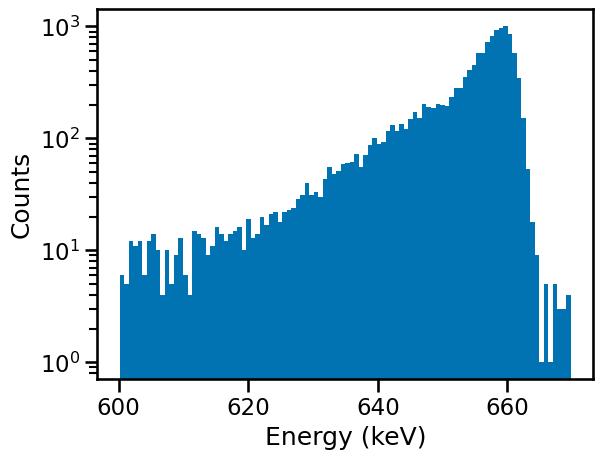

FWHM = 6.24
FWTM = 23.41


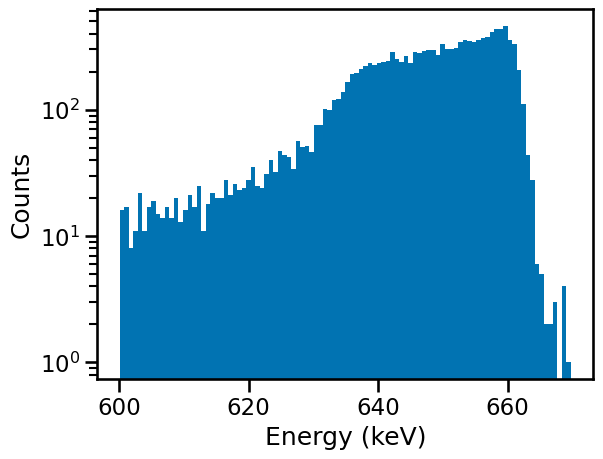

FWHM = 23.24
FWTM = 38.32


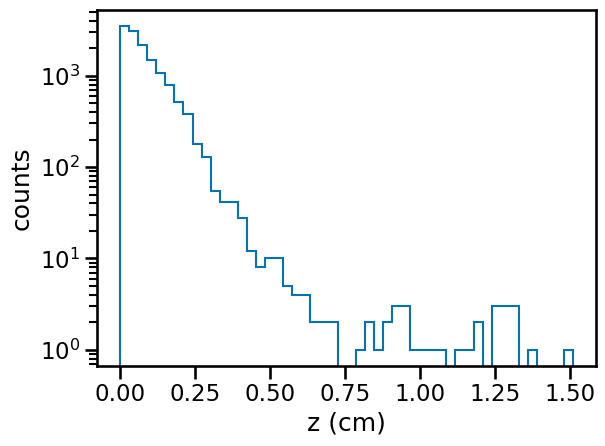

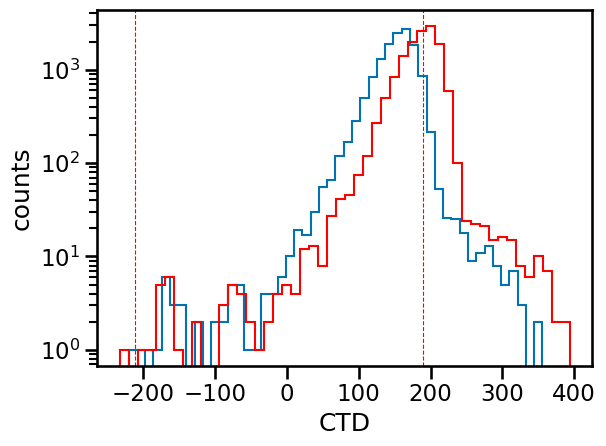

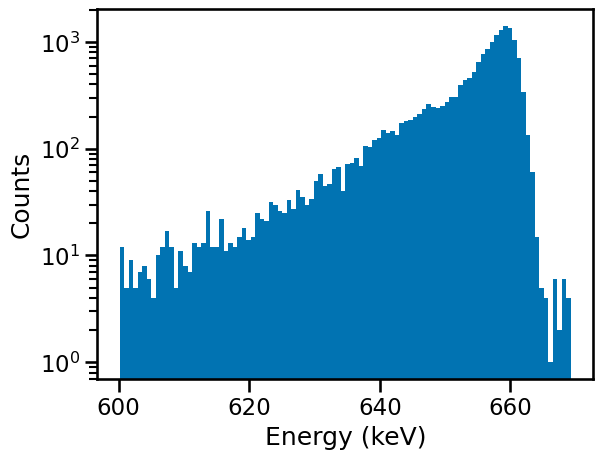

FWHM = 6.0
FWTM = 22.36


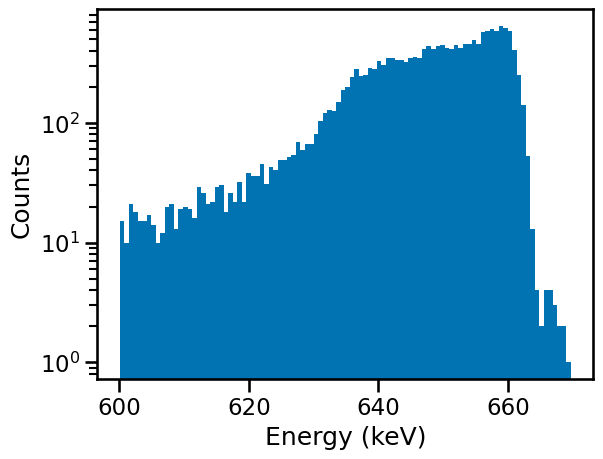

FWHM = 21.44
FWTM = 35.73


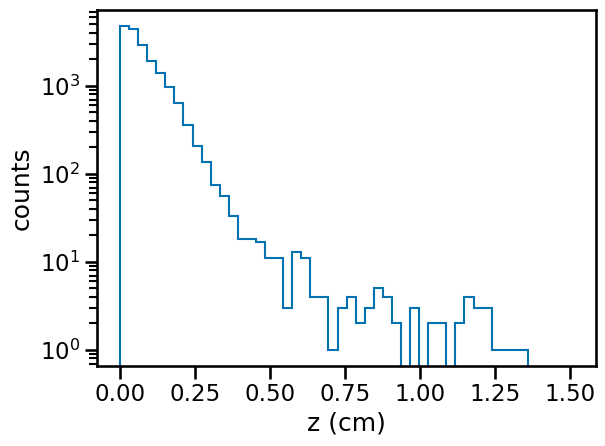

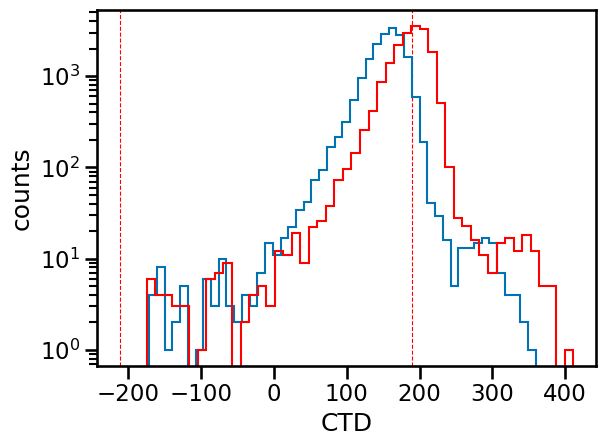

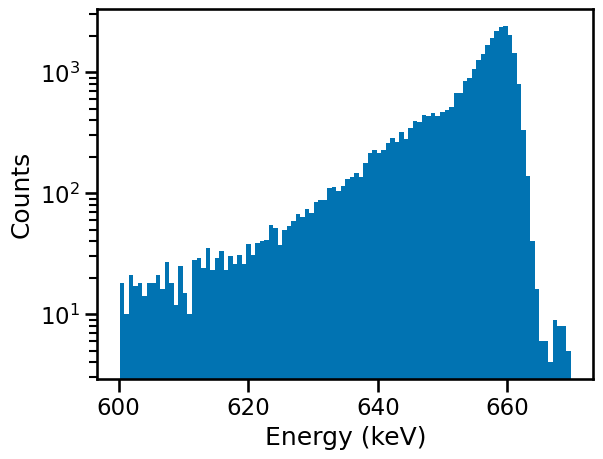

FWHM = 6.07
FWTM = 21.55


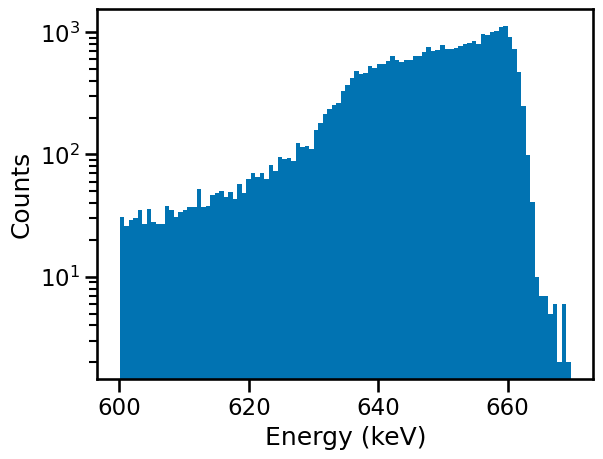

FWHM = 20.4
FWTM = 35.71


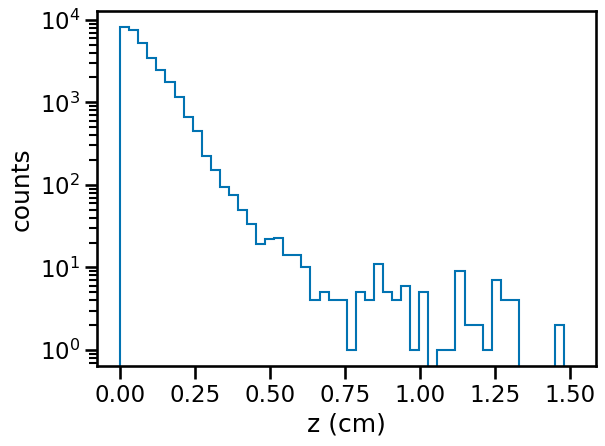

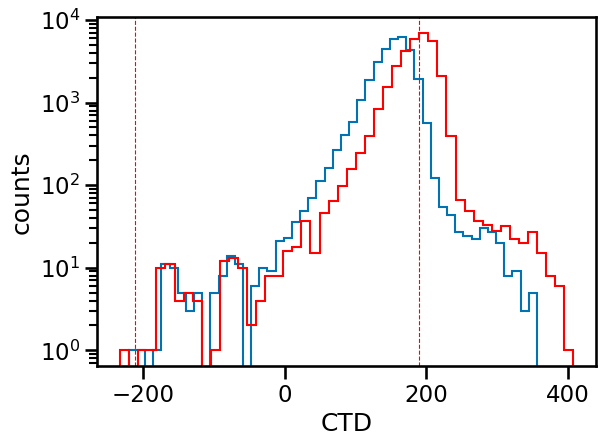

In [9]:
AC_list = ['20240117_Cs137_AC_600V.dat', '20240122_Cs137_AC_600V.dat', '20240119_Cs137_AC_600V.dat', '20240123_Cs137_AC_600V.dat']
DC_list = ['20240124_Cs137_DC_600V.dat', '20240125_Cs137_DC_600V.dat', '20240126_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postroomtemp', 'allDC_postroomtemp', 'allACandDC_postroomtemp']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postroomtemp/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postroomtemp, h_signal_postroomtemp = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax, num_z = 3)

In [9]:
df = depth_correction(df_list[-1], z_list, e_signal_postroomtemp, h_signal_postroomtemp, plot_suffix = 'allACandDC_postroomtemp')

error: (m>k) failed for hidden m: fpcurf0:m=3